In [1]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [2]:
import numpy as np
import pandas as pd

In [3]:
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [4]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func

In [5]:
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [6]:
# reflect an existing database into a new model
Base = automap_base()
# reflect the tables
Base.prepare(engine, reflect=True)

In [7]:
# We can view all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [8]:
# Save references to each table
Measurement = Base.classes.measurement
Station = Base.classes.station

In [9]:
# Create our session (link) from Python to the DB
session = Session(engine)

In [10]:
#converted sql tables to pandas dataframes due to personal preference
M_data = session.query(Measurement)
df1 = pd.read_sql(M_data.statement, engine, index_col="id")
df1.head()

,station,date,prcp,tobs
id,,,,
1,USC00519397,2010-01-01,0.08,65.0
2,USC00519397,2010-01-02,0.00,63.0
3,USC00519397,2010-01-03,0.00,74.0
4,USC00519397,2010-01-04,0.00,76.0
5,USC00519397,2010-01-06,NaN,73.0


In [11]:
S_data = session.query(Station)
df2 = pd.read_sql(S_data.statement, engine, index_col="id")
df2.head()

,station,name,latitude,longitude,elevation
id,,,,,
1,USC00519397,"WAIKIKI 717.2, HI US",21.2716,-157.8168,3.0
2,USC00513117,"KANEOHE 838.1, HI US",21.4234,-157.8015,14.6
3,USC00514830,"KUALOA RANCH HEADQUARTERS 886.9, HI US",21.5213,-157.8374,7.0
4,USC00517948,"PEARL CITY, HI US",21.3934,-157.9751,11.9
5,USC00518838,"UPPER WAHIAWA 874.3, HI US",21.4992,-158.0111,306.6


In [12]:
#merge to tables into one dataframe
data_df = pd.merge(df1,df2,on="station",how="outer")
data_df.head()

,station,date,prcp,tobs,name,latitude,longitude,elevation
0,USC00519397,2010-01-01,0.08,65.0,"WAIKIKI 717.2, HI US",21.2716,-157.8168,3.0
1,USC00519397,2010-01-02,0.00,63.0,"WAIKIKI 717.2, HI US",21.2716,-157.8168,3.0
2,USC00519397,2010-01-03,0.00,74.0,"WAIKIKI 717.2, HI US",21.2716,-157.8168,3.0
3,USC00519397,2010-01-04,0.00,76.0,"WAIKIKI 717.2, HI US",21.2716,-157.8168,3.0
4,USC00519397,2010-01-06,NaN,73.0,"WAIKIKI 717.2, HI US",21.2716,-157.8168,3.0


# Exploratory Climate Analysis

Text(0.5, 1.0, 'Precipitation Total by Day over Last Year')

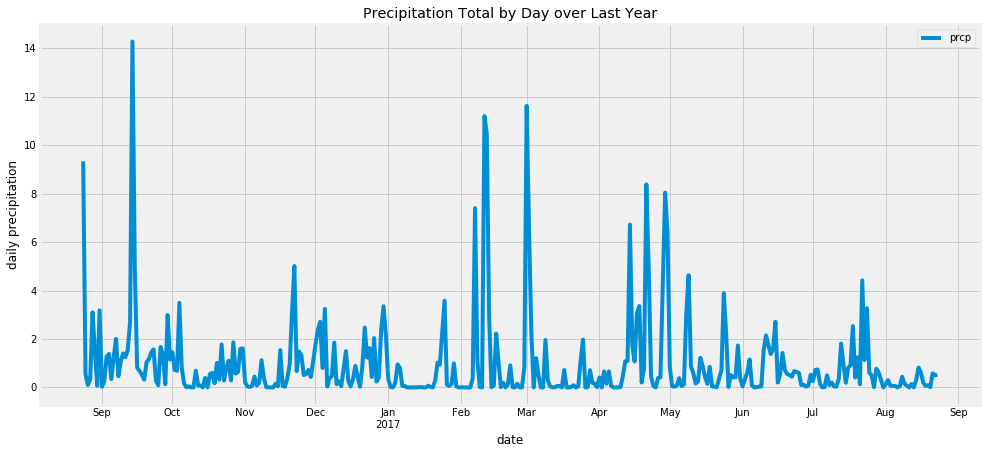

In [21]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results

# Calculate the date 1 year ago from the last data point in the database
data_df['date'] = pd.to_datetime(data_df['date'])
last_date = data_df['date'].max()
first_date = data_df['date'].min()
one_yr_ago = last_date - pd.Timedelta(days=365) 

## Used SQL Alchemy to perform a querys to retrieve the data throughout, 
#but again, prefer to use pandas and grouby/loc functions

# session.query(Measurement.date, func.sum(Measurement.prcp)).\
#     filter(Measurement.date > '2016-08-23').group_by(Measurement.date).\
#     order_by(Measurement.date.asc()).all()

# Save the query results as a Pandas DataFrame and set the index to the date column
# Sort the dataframe by date
prior_year_data = data_df[data_df['date']>one_yr_ago]
prior_year_data = pd.DataFrame(prior_year_data.groupby(['date'])['prcp'].agg(sum))

# Use Pandas Plotting with Matplotlib to plot the data
fig, ax = plt.subplots(figsize=(15,7))
prior_year_data.plot(ax=ax)
plt.ylabel('daily precipitation')
plt.title('Precipitation Total by Day over Last Year')

In [93]:
#export to csv
prior_year_data.to_csv('prior_year_data.csv',index='date')

In [14]:
# Use Pandas to calcualte the summary statistics for the precipitation data
# ***Note: this is different from homework example
# I suspect that example only uses summary statistics from one weather station, 
# as opposed to the entire data set.
# Directions not entirely clear

data_df[['prcp']].describe()

,prcp
count,18103.000000
mean,0.160644
std,0.468746
min,0.000000
25%,0.000000
50%,0.010000
75%,0.110000
max,11.530000


In [25]:
# Design a query to show how many stations are available in this dataset?
# pandas verions

# stations = data_df['station'].unique()
# len(stations)

#SQL Alchemy Version
stations = session.query(Station.station).group_by(Station.station).all()
len(stations)

9

In [39]:
# What are the most active stations? (i.e. what stations have the most rows)?
# List the stations and the counts in descending order.

# pandas version
# station_count = pd.DataFrame(data_df['station'].value_counts()).sort_values('station',ascending=False)
# station_count

#SQL Alchemy Version
station_count = session.query(Measurement.station, func.count(Measurement.station)).group_by(Measurement.station).order_by(func.count(Measurement.station).desc()).all()
station_count

[('USC00519281', 2772),
 ('USC00519397', 2724),
 ('USC00513117', 2709),
 ('USC00519523', 2669),
 ('USC00516128', 2612),
 ('USC00514830', 2202),
 ('USC00511918', 1979),
 ('USC00517948', 1372),
 ('USC00518838', 511)]

In [42]:
# Using the station id from the previous query, calculate the lowest temperature recorded, 
# highest temperature recorded, and average temperature most active station?

# pandas version

# station_summary = pd.DataFrame(data_df.groupby('station').agg({'tobs':['count',min,max,'mean']}))
# station_summary.columns = ["_".join(x) for x in station_summary.columns.ravel()]
# station_summary.sort_values('tobs_count',ascending=False)

#SQL Alchemy Version

session.query(Measurement.station, func.min(Measurement.tobs),func.max(Measurement.tobs),func.avg(Measurement.tobs),func.count(Measurement.station)).\
    group_by(Measurement.station).\
    order_by(func.count(Measurement.station).desc()).all()

[('USC00519281', 54.0, 85.0, 71.66378066378067, 2772),
 ('USC00519397', 56.0, 87.0, 74.55323054331865, 2724),
 ('USC00513117', 59.0, 85.0, 72.68918420081211, 2709),
 ('USC00519523', 56.0, 85.0, 74.5436493068565, 2669),
 ('USC00516128', 58.0, 84.0, 70.91500765696784, 2612),
 ('USC00514830', 58.0, 85.0, 74.8732970027248, 2202),
 ('USC00511918', 53.0, 87.0, 71.61596766043456, 1979),
 ('USC00517948', 58.0, 87.0, 74.68440233236151, 1372),
 ('USC00518838', 58.0, 83.0, 72.72407045009784, 511)]

Text(0.5, 1.0, 'Count of Daily Temperature over Final Year of Data for Station USC00519281')

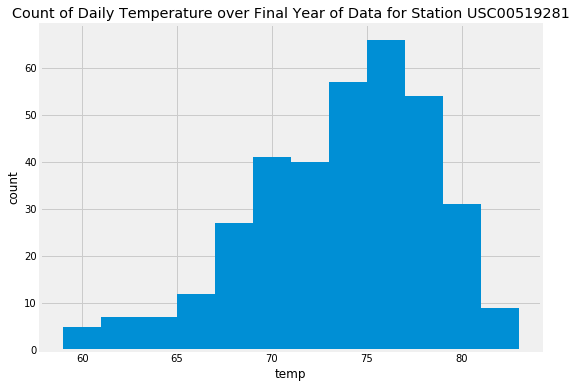

In [49]:
# Choose the station with the highest number of temperature observations.
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram
USC00519281 = data_df.loc[(data_df['station'] == 'USC00519281')] 
date = USC00519281['date'].max() - pd.Timedelta(days=365)

USC00519281 = USC00519281.loc[(USC00519281['date'] > date)]
n = int(USC00519281['tobs'].max() - USC00519281['tobs'].min())
fig, ax = plt.subplots(figsize=(8,6))
ax.hist(USC00519281['tobs'].tolist(), bins=12)
plt.ylabel('count')
plt.xlabel('temp')
plt.title("Count of Daily Temperature over Final Year of Data for Station USC00519281")

In [96]:
# This function called `calc_temps` will accept start date and end date in the format '%Y-%m-%d' 
# and return the minimum, average, and maximum temperatures for that range of dates
def calc_temps(start_date, end_date):
    """TMIN, TAVG, and TMAX for a list of dates.
    
    Args:
        start_date (string): A date string in the format %Y-%m-%d
        end_date (string): A date string in the format %Y-%m-%d
        
    Returns:
        TMIN, TAVE, and TMAX
    """
    
    return session.query(func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)).\
        filter(Measurement.date >= start_date).filter(Measurement.date <= end_date).all()

# function usage example
print(calc_temps('2012-02-28', '2012-03-05'))

[(62.0, 69.57142857142857, 74.0)]


In [65]:
# Use your previous function `calc_temps` to calculate the tmin, tavg, and tmax 
# for your trip using the previous year's data for those same dates.

#Note: Picking Trip Start Date of 1/1/2018 and Trip End Date of 1/8/2018

#declare start date and end date as datetime objects
trip_start = dt.datetime.strptime('01012018', '%m%d%Y').date()
trip_end = dt.datetime.strptime('01082018', '%m%d%Y').date()

#use timedelta to get last years dates
trip_start_last_yr = trip_start - dt.timedelta(days=365)
trip_end_last_yr = trip_end - dt.timedelta(days=365)

#call function to pull last years data
prev_year_data = calc_temps(trip_start_last_yr.strftime('%Y-%m-%d'), trip_end_last_yr.strftime('%Y-%m-%d'))
print(prev_year_data)

[(60.0, 68.27659574468085, 74.0)]


Text(0, 0.5, 'Temp (F)')

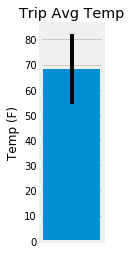

In [74]:
# Plot the results from your previous query as a bar chart. 
# Use "Trip Avg Temp" as your Title
# Use the average temperature for the y value
# Use the peak-to-peak (tmax-tmin) value as the y error bar (yerr)
variance = prev_year_data[0][2] - prev_year_data[0][0]
f, ax = plt.subplots(figsize=(1,4))
plt.bar(1,prev_year_data[0][1], yerr=variance,width=.35)
plt.xticks([])
plt.title('Trip Avg Temp')
plt.ylabel('Temp (F)')

In [85]:
# Calculate the total amount of rainfall per weather station for your trip dates using the previous year's matching dates.
# Sort this in descending order by precipitation amount and list the station, name, latitude, longitude, and elevation
summary_df = data_df.groupby(['station','name','latitude','longitude','elevation'],as_index=False).agg({"prcp": "sum"})
summary_df.sort_values(by='prcp', ascending=False)

,station,name,latitude,longitude,elevation,prcp
3,USC00516128,"MANOA LYON ARBO 785.2, HI US",21.33310,-157.80250,152.4,1068.09
6,USC00519281,"WAIHEE 837.5, HI US",21.45167,-157.84889,32.9,588.64
1,USC00513117,"KANEOHE 838.1, HI US",21.42340,-157.80150,14.6,382.62
8,USC00519523,"WAIMANALO EXPERIMENTAL FARM, HI US",21.33556,-157.71139,19.5,295.68
2,USC00514830,"KUALOA RANCH HEADQUARTERS 886.9, HI US",21.52130,-157.83740,7.0,234.49
7,USC00519397,"WAIKIKI 717.2, HI US",21.27160,-157.81680,3.0,131.62
0,USC00511918,"HONOLULU OBSERVATORY 702.2, HI US",21.31520,-157.99920,0.9,92.68
5,USC00518838,"UPPER WAHIAWA 874.3, HI US",21.49920,-158.01110,306.6,70.87
4,USC00517948,"PEARL CITY, HI US",21.39340,-157.97510,11.9,43.44


## Optional Challenge Assignment

In [86]:
# Create a query that will calculate the daily normals 
# (i.e. the averages for tmin, tmax, and tavg for all historic data matching a specific month and day)

def daily_normals(date):
    """Daily Normals.
    
    Args:
        date (str): A date string in the format '%m-%d'
        
    Returns:
        A list of tuples containing the daily normals, tmin, tavg, and tmax
    
    """
    
    sel = [func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)]
    return session.query(*sel).filter(func.strftime("%m-%d", Measurement.date) == date).all()
    
daily_normals("01-01")[0]

(62.0, 69.15384615384616, 77.0)

In [87]:
# calculate the daily normals for your trip
# push each tuple of calculations into a list called `normals`

# Set the start and end date of the trip
trip_start_date = '01-01-2018'
trip_end_date = '01-07-2018'

# Use the start and end date to create a range of dates
dates = pd.date_range(trip_start_date,trip_end_date)

# Stip off the year and save a list of %m-%d strings
dates_string = dates.strftime("%m-%d"); 

# Loop through the list of %m-%d strings and calculate the normals for each date
normals = []
for date in dates_string:
    normals.append(daily_normals(date)[0])
    
normals

[(62.0, 69.15384615384616, 77.0),
 (60.0, 69.39622641509433, 77.0),
 (62.0, 68.9090909090909, 77.0),
 (58.0, 70.0, 76.0),
 (56.0, 67.96428571428571, 76.0),
 (61.0, 68.96491228070175, 76.0),
 (57.0, 68.54385964912281, 76.0)]

In [88]:
# Load the previous query results into a Pandas DataFrame and add the `trip_dates` range as the `date` index
normals_df = pd.DataFrame(normals,columns=['tmin','tmax','tavg'],index=dates)
normals_df
# normals_df1 = pd.DataFrame(normals.tolist(), index=normals_df.index)  

,tmin,tmax,tavg
2018-01-01,62.0,69.153846,77.0
2018-01-02,60.0,69.396226,77.0
2018-01-03,62.0,68.909091,77.0
2018-01-04,58.0,70.000000,76.0
2018-01-05,56.0,67.964286,76.0
2018-01-06,61.0,68.964912,76.0
2018-01-07,57.0,68.543860,76.0


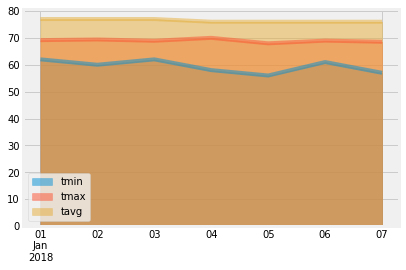

In [89]:
# Plot the daily normals as an area plot with `stacked=False`
normals_df.plot.area(stacked=False)